# UNIDAD 4 - CLASIFICADOR NAIVE BAYES
## Docente: Ruth Rosario Chirinos Contreras
## Fecha de Entrega: 13/Sept/2023 19:00 PM

# Clasificacion de SMS Spam con Naive Bayes

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Explorando el Dataset

In [5]:
data = pd.read_csv(r'C:\Users\nicol\Documents\DATA_SCIENCE_UPB_TASKS\00 Data\01_datasets\spam.csv', encoding='latin-1')
data.head(n=10)
# 'ham': es e-mail que no es Spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


## Distribucion spam/non-spam plots

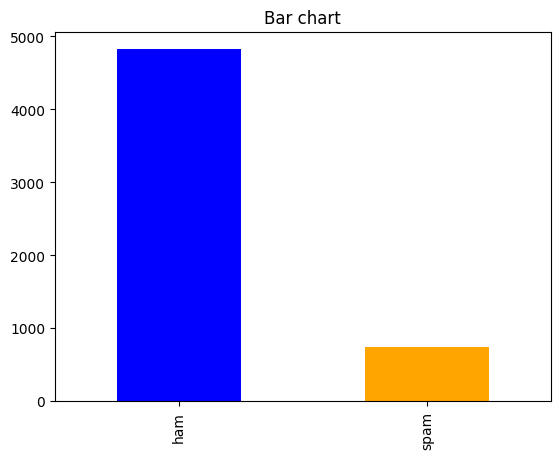

In [6]:
count_Class=pd.value_counts(data["v1"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

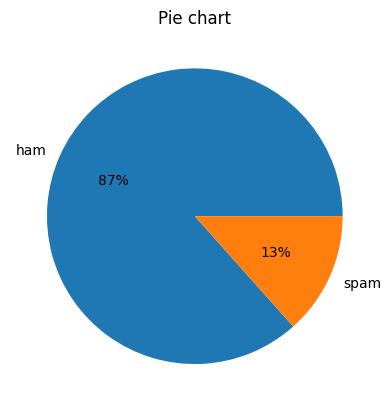

In [7]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## Analisis de Texto

Queremos encontrar las frecuencias de las palabras en los mensajes spam y no spam. Las palabras de los mensajes serán características del modelo.<p>
Usamos la función Contador.

In [8]:
#data[   data['v1']=='ham'    ]

# SMS normales
count1 = Counter(" ".join(data[data['v1']=='ham']["v2"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})

# SMS con spam
count2 = Counter(" ".join(data[data['v1']=='spam']["v2"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

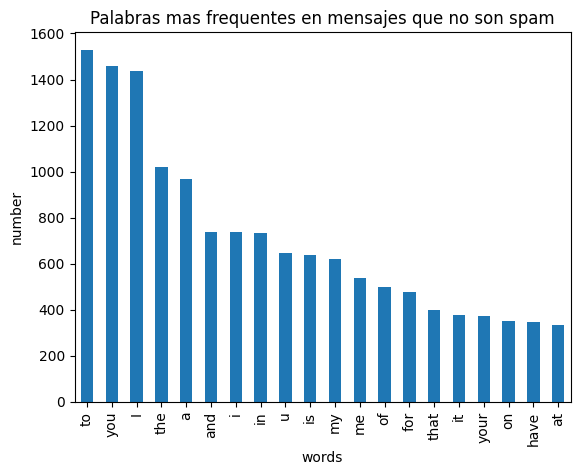

In [9]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('Palabras mas frequentes en mensajes que no son spam')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

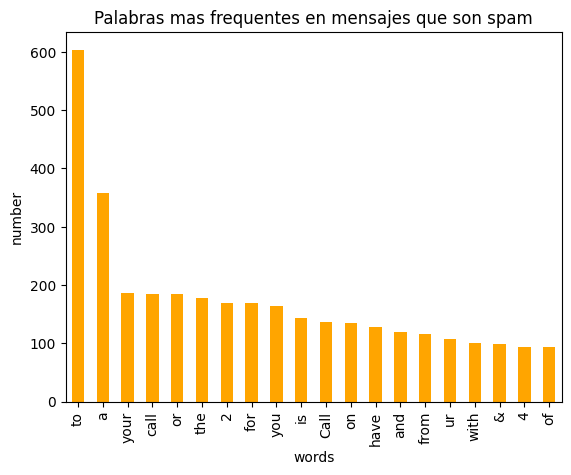

In [10]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('Palabras mas frequentes en mensajes que son spam')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

Podemos ver que la mayoría de las palabras frecuentes en ambas clases son palabras vacías como 'a', 'a', 'o', etc. <p>
Con palabras vacías nos referimos a las palabras más comunes de un idioma, no existe una lista única y universal de palabras vacías. <p>

## Ingenieria de Caracteristicas (Feature engineering)

El preprocesamiento de texto, la tokenización y el filtrado de palabras vacías se incluyen en un componente de alto nivel que es capaz de crear un diccionario de características y transformar documentos en vectores de características.<p>
**Eliminamos las palabras vacías para mejorar los análisis**

In [11]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["v2"])
np.shape(X)

(5572, 8404)

Hemos creado más de 8400 funciones nuevas. La nueva característica $j$ en la fila $i$ es igual a 1 si la palabra $w_{j}$ aparece en el ejemplo de texto $i$. Si no aparece sera 0.

## Analisis Predictivo (Predictive Analysis)

**Mi objetivo es predecir si un nuevo SMS es spam o no. Supongo que es mucho peor clasificar erróneamente lo que no es spam que clasificar erróneamente un spam. (No quiero tener falsos positivos)**
<p>
La razón es que normalmente no reviso los mensajes de spam.<p> Las dos situaciones posibles son:<p>
1. Nuevos SMS spam en mi bandeja de entrada. (Falso negativo).<p>
RESULTADO: Lo borro.<p>
2. Nuevos SMS que no son spam en mi carpeta de spam (falso positivo).<p> RESULTADO: Probablemente no lo leo. <p>
¡¡¡Prefiero la primera opción!!!

Primero transformamos la variable spam/no spam en una variable binaria, luego dividimos nuestro conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba.

In [12]:
data["v1"]=data["v1"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['v1'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


### Clasificador Multinomial naive bayes

Entrenamos diferentes modelos bayes cambiando el parámetro de regularización $\alpha$. <p>
Evaluamos la exactitud, recuperación y precisión del modelo con el conjunto de prueba.

In [13]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    #Definimos el modelo
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    #Entrenamos el modelo
    bayes.fit(X_train, y_train)
    #Obtenemos los scores
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1

¡Veamos los primeros 10 modelos de aprendizaje y sus métricas!

In [14]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns =
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998661,0.974443,0.920635,0.895753
1,0.11001,0.997857,0.976074,0.936508,0.893939
2,0.22001,0.997857,0.977162,0.936508,0.900763
3,0.33001,0.997589,0.977162,0.936508,0.900763
4,0.44001,0.997053,0.977162,0.936508,0.900763
5,0.55001,0.996250,0.976618,0.936508,0.897338
6,0.66001,0.996518,0.976074,0.932540,0.896947
7,0.77001,0.996518,0.976074,0.924603,0.903101
8,0.88001,0.996250,0.976074,0.924603,0.903101
9,0.99001,0.995982,0.976074,0.920635,0.906250


Selecciono el modelo con mayor precisión de prueba.

In [15]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

**Mi mejor modelo no produce ningún falso positivo, que es nuestro objetivo.** <p>
¡Veamos si hay más de un modelo con 100% de precisión!

In [16]:
models[models['Test Precision']==1].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
143,15.73001,0.979641,0.969549,0.777778,1.0
144,15.84001,0.979641,0.969549,0.777778,1.0
145,15.95001,0.979641,0.969549,0.777778,1.0
146,16.06001,0.979373,0.969549,0.777778,1.0
147,16.17001,0.979373,0.969549,0.777778,1.0


Entre estos modelos con mayor precisión posible vamos a seleccionar cuál tiene mayor precisión de prueba.

In [17]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

#### Matriz de Confusion (Confusion matrix) con el clasificador naive bayes

In [18]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,56,196


Hemos clasificado erróneamente 56 correos electrónicos no deseados como spam y **0 spam como spam** (que es lo que queríamos)

### **Ejercicios**

Entrenamos diferentes modelos bayes cambiando el parámetro de regularización $\alpha$. <p>
Evaluamos la exactitud, recuperación y precisión del modelo con el conjunto de prueba.

In [22]:
#valor= <----modifique el valor, por ejemplo: 100000---->
valor = 1
list_alpha = np.arange(1/valor, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    #Definimos el modelo
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    #Entrenamos el modelo
    bayes.fit(X_train, y_train)
    #Obtenemos los scores
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1

¡Veamos los primeros 10 modelos de aprendizaje y sus métricas, y los ultimos 10 modelos de aprendizaje y sus métricas!

In [23]:
# Aqui tu codigo
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns =
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,1.00,0.995982,0.976074,0.920635,0.906250
1,1.11,0.995446,0.977705,0.920635,0.916996
2,1.22,0.995446,0.978249,0.920635,0.920635
3,1.33,0.995178,0.978793,0.920635,0.924303
4,1.44,0.995178,0.980968,0.920635,0.939271
5,1.55,0.994910,0.980968,0.920635,0.939271
6,1.66,0.994910,0.981512,0.920635,0.943089
7,1.77,0.994374,0.981512,0.920635,0.943089
8,1.88,0.994107,0.981512,0.920635,0.943089
9,1.99,0.994107,0.981512,0.916667,0.946721


In [24]:
models.tail(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
163,18.93,0.977498,0.966830,0.757937,1.0
164,19.04,0.977498,0.966830,0.757937,1.0
165,19.15,0.977498,0.966830,0.757937,1.0
166,19.26,0.976694,0.966830,0.757937,1.0
167,19.37,0.976694,0.966830,0.757937,1.0
168,19.48,0.976426,0.966286,0.753968,1.0
169,19.59,0.975891,0.966286,0.753968,1.0
170,19.70,0.975891,0.966286,0.753968,1.0
171,19.81,0.975355,0.966286,0.753968,1.0
172,19.92,0.975087,0.966286,0.753968,1.0


### Evaluando el modelo con mayor presicion
1.   Selecciona el modelo con mayor precisión de prueba
2.   Muestra sus metricas: Train Accuracy , Test Accuracy , Test Recall , Test Precision
3.   Elabora su matriz de confusion



In [25]:
# Aqui tu codigo
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             15.740000
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 134, dtype: float64

In [26]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,62,190


### Evaluando el modelo con menor presicion
1.   Selecciona el modelo con menor precisión de prueba
2.   Muestra sus metricas: Train Accuracy , Test Accuracy , Test Recall , Test Precision
3.   Elabora su matriz de confusion

In [28]:
# Aqui tu codigo
worst_index = models['Test Precision'].idxmin()
models.iloc[worst_index, :]

alpha             1.000000
Train Accuracy    0.995982
Test Accuracy     0.976074
Test Recall       0.920635
Test Precision    0.906250
Name: 0, dtype: float64

In [29]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,62,190
